In [1]:
import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
import numpy as np
import pandas
import seaborn as sns
import warnings
from ipywidgets import FloatProgress
from IPython.display import display

In [37]:
debug_rounds = False
debug_matches = False

In [30]:
def d20():
    return np.random.randint(1,21)

def do_rounds_and_update(a,b,rounds,df):
    wins = do_match(a,b,rounds)
    a_wins = wins[0]
    b_wins = wins[1]
    a_id = a[0]
    b_id = b[0]
    df.at[a_id,'total_wins'] = df.at[a_id,'total_wins'] + a_wins
    df.at[b_id,'total_wins'] = df.at[b_id,'total_wins'] + b_wins
    if a_wins > b_wins:
        df.at[a_id,'pair_wins'] = df.at[a_id,'pair_wins'] + 1
    else:
        df.at[b_id,'pair_wins'] = df.at[b_id,'pair_wins'] + 1
    return df

def do_match(a,b,rounds):
    a_wins = 0
    b_wins = 0
    for _ in np.arange(rounds):
        wins = do_round(a,b)
        a_wins = a_wins + wins[0]
        b_wins = b_wins + wins[1]
    if debug_matches:
        print ("After %d rounds %s won %d times and %s won %d times" % (rounds,a.name,a_wins,b.name,b_wins))
    return [a_wins,b_wins]

def do_round( a, b ):
    a_init = d20() + a.init
    if debug_rounds:
        print("%s rolled %d init" % (a.name,a_init))
    b_init = d20() + b.init
    if debug_rounds:
        print("%s rolled %d init" % (b.name,b_init))
    if (a_init >= b_init):
        first = a.copy()
        second = b.copy()
        in_order = True
    else:
        first = b.copy()
        second = a.copy()
        in_order = False
    round = 0
    while (first.hp > 0 and second.hp > 0):
        if debug_rounds:
            print("    Round %d: %s hp is %d and %s hp is %d" % (round+1, first.name,first.hp,second.name,second.hp))
        round = round + 1
        first,second = do_attack(first,second)
        if (second.hp <= 0):
            if debug_rounds:
                print("%s is dead" % second.name)
            if in_order:
                return [1,0] #a went first and won
            else:
                return [0,1] #b went first and won
        else:
            second,first = do_attack(second,first)
            if (first.hp <= 0):
                if debug_rounds:
                    print("%s is dead" % first.name)
                if in_order:
                    return [0,1] #b went second and won
                else:
                    return [1,0] #a went second and won
    """Something went wrong here, nobody wins"""
    return [0,0]
    
def do_attack( attacker, target ):
    if debug_rounds:
        print ("        %s makes %d attacks against %s" % (attacker.name, attacker.att_num, target.name))
    for _ in np.arange(attacker.att_num):
        attack = d20() + attacker.hit_mod
        if (attack >= target.ac):
            target.hp = target.hp - attacker.dam_avg
            if debug_rounds:
                print("            %s hits %s for %d damage" % (attacker.name, target.name, attacker.dam_avg ))
        else:
            if debug_rounds:
                print("            %s misses %s" % (attacker.name, target.name))
    return [attacker, target]

In [31]:
# TODO: determine rounds for a 95% confidence interval in accordance with:
# https://calhoun.nps.edu/bitstream/handle/10945/798/NPS-MAE-04-005.pdf?sequence=1

def run_matches(creatures,rounds):
    rows = creatures.shape[0]
    creatures['pair_wins'] = np.zeros(rows)
    creatures['total_wins'] = np.zeros(rows)

    matches = (rows**2+rows)/2

    f = FloatProgress(min=0, max=matches, description="Contest: ")
    display(f)

    print("Performing %d matches of %d rounds each" % (matches,rounds))
    for i in np.arange(rows):
        a = creatures.take([i]).to_records()[0]
        for j in np.arange(i+1,rows):
            b = creatures.take([j]).to_records()[0]
            creatures = do_rounds_and_update(a,b,rounds,creatures)
            f.value = f.value + 1
    
    filename = "creatures_%02d.csv" % (rounds)

In [ ]:
creatures = pandas.read_csv('creatures.csv')
run_matches(creatures,100)
creatures.to_csv('creatures_100.csv')

r=0.818796


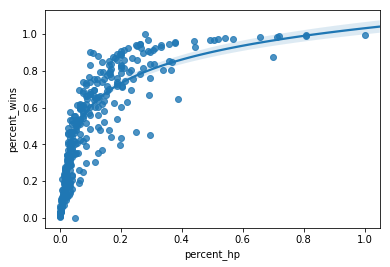

In [5]:
creatures = pandas.read_csv('creatures_100.csv')
rows = creatures.shape[0]
creatures['percent_wins'] = creatures['pair_wins'] / (rows-1)
max_hp = creatures.loc[creatures['hp'].idxmax()]['hp']
creatures['percent_hp'] = creatures['hp'] / max_hp
creatures = creatures.sort_values(['percent_wins'],ascending=False)
warnings.filterwarnings('ignore')
sns.regplot(creatures['percent_hp'],creatures['percent_wins'],logx=True)
r = np.corrcoef(creatures['percent_hp'],10 ** creatures['percent_wins'])[0][1]
print("r=%2f" % r)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11359a860>]],
      dtype=object)

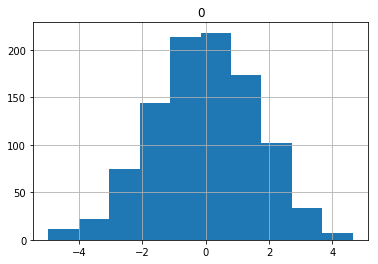

In [6]:
def gen_init(amount):
    """Generate initiative modifiers in range -5,5 with normal distribution"""
    s = np.round(np.random.normal(0, 1.66, amount),2)
    p = pandas.DataFrame(data=s)
    p = p[p[0].between(-5, 5, inclusive=True)]
    return p

p = gen_init(1000)
p.hist(bins=10)

In [36]:
creatures_avg = pandas.read_csv('creatures.csv')
creatures_avg = creatures_avg.groupby('cr').mean().apply(np.round).astype(int).reset_index()
creatures_avg['name'] = creatures_avg['cr']
run_matches(creatures_avg,100)

FloatProgress(value=0.0, description='Contest: ', max=406.0)

Performing 406 matches of 100 rounds each
After 100 rounds 0.0 won 0 times and 0.125 won 100 times
After 100 rounds 0.0 won 0 times and 0.25 won 100 times
After 100 rounds 0.0 won 0 times and 0.5 won 100 times
After 100 rounds 0.0 won 0 times and 1.0 won 100 times
After 100 rounds 0.0 won 0 times and 2.0 won 100 times
After 100 rounds 0.0 won 0 times and 3.0 won 100 times
After 100 rounds 0.0 won 0 times and 4.0 won 100 times
After 100 rounds 0.0 won 0 times and 5.0 won 100 times
After 100 rounds 0.0 won 0 times and 6.0 won 100 times
After 100 rounds 0.0 won 0 times and 7.0 won 100 times
After 100 rounds 0.0 won 0 times and 8.0 won 100 times
After 100 rounds 0.0 won 0 times and 9.0 won 100 times
After 100 rounds 0.0 won 0 times and 10.0 won 100 times
After 100 rounds 0.0 won 0 times and 11.0 won 100 times
After 100 rounds 0.0 won 0 times and 12.0 won 100 times
After 100 rounds 0.0 won 0 times and 13.0 won 100 times
After 100 rounds 0.0 won 0 times and 14.0 won 100 times
After 100 round

After 100 rounds 2.0 won 0 times and 30.0 won 100 times
After 100 rounds 3.0 won 98 times and 4.0 won 2 times
After 100 rounds 3.0 won 3 times and 5.0 won 97 times
After 100 rounds 3.0 won 1 times and 6.0 won 99 times
After 100 rounds 3.0 won 1 times and 7.0 won 99 times
After 100 rounds 3.0 won 0 times and 8.0 won 100 times
After 100 rounds 3.0 won 4 times and 9.0 won 96 times
After 100 rounds 3.0 won 0 times and 10.0 won 100 times
After 100 rounds 3.0 won 0 times and 11.0 won 100 times
After 100 rounds 3.0 won 3 times and 12.0 won 97 times
After 100 rounds 3.0 won 0 times and 13.0 won 100 times
After 100 rounds 3.0 won 0 times and 14.0 won 100 times
After 100 rounds 3.0 won 0 times and 15.0 won 100 times
After 100 rounds 3.0 won 0 times and 16.0 won 100 times
After 100 rounds 3.0 won 0 times and 17.0 won 100 times
After 100 rounds 3.0 won 100 times and 19.0 won 0 times
After 100 rounds 3.0 won 0 times and 20.0 won 100 times
After 100 rounds 3.0 won 0 times and 21.0 won 100 times
Afte

After 100 rounds 11.0 won 100 times and 19.0 won 0 times
After 100 rounds 11.0 won 0 times and 20.0 won 100 times
After 100 rounds 11.0 won 0 times and 21.0 won 100 times
After 100 rounds 11.0 won 0 times and 22.0 won 100 times
After 100 rounds 11.0 won 0 times and 23.0 won 100 times
After 100 rounds 11.0 won 0 times and 24.0 won 100 times
After 100 rounds 11.0 won 0 times and 30.0 won 100 times
After 100 rounds 12.0 won 0 times and 13.0 won 100 times
After 100 rounds 12.0 won 0 times and 14.0 won 100 times
After 100 rounds 12.0 won 0 times and 15.0 won 100 times
After 100 rounds 12.0 won 0 times and 16.0 won 100 times
After 100 rounds 12.0 won 0 times and 17.0 won 100 times
After 100 rounds 12.0 won 100 times and 19.0 won 0 times
After 100 rounds 12.0 won 0 times and 20.0 won 100 times
After 100 rounds 12.0 won 0 times and 21.0 won 100 times
After 100 rounds 12.0 won 0 times and 22.0 won 100 times
After 100 rounds 12.0 won 0 times and 23.0 won 100 times
After 100 rounds 12.0 won 0 tim

In [39]:
rows = creatures_avg.shape[0]
creatures_avg['percent_wins'] = creatures_avg['pair_wins'] / (rows-1)
max_hp = creatures_avg.loc[creatures_avg['hp'].idxmax()]['hp']
creatures_avg['percent_hp'] = creatures_avg['hp'] / max_hp
creatures_avg = creatures_avg.sort_values(['percent_wins'],ascending=False)
creatures_avg.to_csv('creatures_avg.csv')